## Additionally Statistical Modeling Techniques for Time Series 

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.tools import diff 
from pathlib import Path 
import warnings
warnings.filterwarnings('ignore')
plt.rc("figure", figsize=(16,5))


## Forecasting time series data using auto_arima

* For this part we need to install the package pmdarima
    - this package includes auto_arima for automating ARIMA hyperparameter 

* auto_arima automates the process for finding the optimal parameters. The auto_arima function uses a stepwise algorithm that is faster and more efficient than a full grid search 

* When stepwise=True, auto_arima performs a stepwise search (default)
* With stepwise=False, it performs a brute-force grid search (full search)
* With random=True, it performs a random search

stepwise is an optimization technique that utilizes grid search more efficiently. This is accomplished using unit root tests and minimizing information criteria (example: AIC and Maximum Likelihood Estimation (MLE))

Additionally, auto_arima can handle seasonal and non-seasonal ARIMA models. If seasonal ARIMA is desired, we will need to set seasonal=True for auto_arima to optimize over the (P,D,Q) values


Here we will be using the milk_production data, and we must remember from earlier that this dataset contains both trend and seasonality, so we will be training a SARIMA model. 

In [3]:
# import packages and data 
import pmdarima as pm 
milk_file = Path('../TimeSeriesAnalysisWithPythonCookbook/Data/milk_production.csv')
milk = pd.read_csv(milk_file,
                   index_col='month',
                   parse_dates=True)

In [4]:
# Split the dataset into train and test sets
# using standard sci-kit
from sklearn.model_selection import train_test_split
train, test = train_test_split(milk, test_size=0.10, shuffle=False)

In [7]:
# Same splits using pmdarima
train, test = pm.model_selection.train_test_split(milk, test_size=0.10)

print(f'Train: {train.shape}')
print(f'Test: {test.shape}')

Train: (151, 1)
Test: (17, 1)


#### Using auto_arima:

* test parameter specifies the type of unit root test to use to detect stationarity to determine the differencing order (d)

* The default test is _kpss_
* we will change the parameter to use ADF test instead
* seasonal_test is used to determine the order (D) for seasonal differencing. Default is OCSB

We know that the data has a seasonal pattern, so we will need to provide values for the two parameters:
* seasonal=True 
* m=12 (the number of periods in a season)

If these are not set, the model will only search for the non-seasonal order (p,d,q)



In [8]:
auto_model = pm.auto_arima(train,
                           seasonal=True,
                           m=12, 
                           test='adf', 
                           stepwise=True)

auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  151
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -475.008
Date:                            Sat, 15 Apr 2023   AIC                            956.016
Time:                                    12:51:30   BIC                            964.798
Sample:                                01-01-1962   HQIC                           959.585
                                     - 07-01-1974                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2714      0.082     -3.326      0.001      -0.431      -0.111
ma.S.L12      -0.6233      0.079     -7.908      0.000      -0.778      -0.469
sigma2        54.7638      5.498      9.960      0.000      43.987      65.540
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                31.78
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                             0.74
Prob(H) (two-sided):                  0.50   Kurtosis:                         4.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [9]:
# If we want to observe the score of the trained model at each iteration, we can 
# use trace=True 

auto_model = pm.auto_arima(train, seasonal=True, m=12, test='adf', stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=961.878, Time=0.60 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1005.341, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=971.814, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=956.016, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=996.508, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=957.982, Time=0.17 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=957.967, Time=0.29 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=971.938, Time=0.07 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=960.016, Time=0.38 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=964.474, Time=0.06 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=957.884, Time=0.12 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=957.783, Time=0.14 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=956.436, Time=0.09 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=959.701, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12] interce

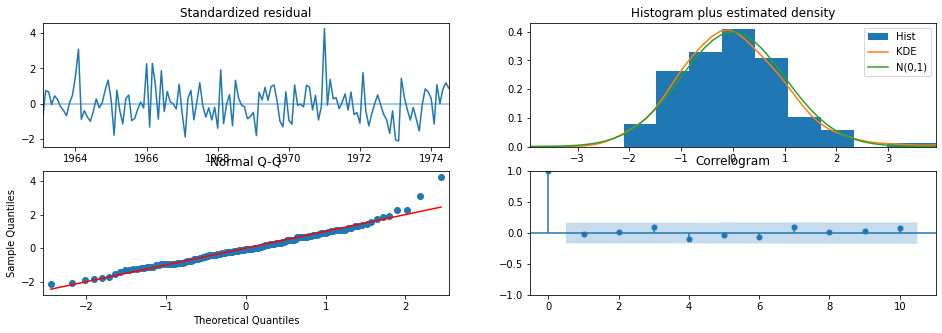

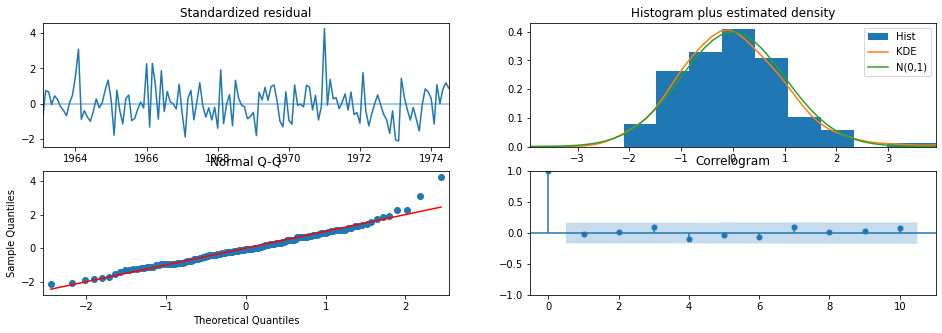

In [10]:
# Inspect the residuals to gauge the overall performance of the model by using the plot_diagnostics

auto_model.plot_diagnostics()

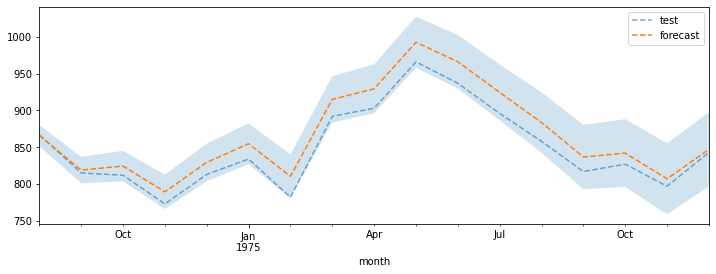

In [11]:
# To make a prediction, we can use the predict method
# Need to provide the number of periods to forecast forward into the future
# obtain confidence intervals with the return_conf_int 

n = test.shape[0]
forecast, conf_interval = auto_model.predict(n_periods=n, return_conf_int=True)
lower_ci, upper_ci = zip(*conf_interval)
index=test.index 
ax = test.plot(style='--', alpha=0.6, figsize=(12,4))
pd.Series(forecast, index=index).plot(style='--', ax=ax)
plt.fill_between(index, lower_ci, upper_ci, alpha=0.2)
plt.legend(['test', 'forecast'])
plt.show()

In [12]:
# Notice that the forecast line lies in the middle of the shaded area. This represents the 
# mean of the upper and lower bounds. 

sum(forecast) == sum(conf_interval.mean(axis=1))


True

The ndiffs function performs stationarity tests to determine the differencing order (d), to make the time series stationary. The tests include the ADF test, the Kwiatkowski-Philips-Schmidt-Shin (kpss) test and the Phillips-Perron (pp) test. 

Similarly, the nsdiffs function helps estimate the number of seasonal differencing orders (p) that are needed. The implementation covers two tests - the Osborn-Chui-Smith-Birchenhall (ocsb) and Canova-Hansen (ch) tests:


In [19]:
from pmdarima.arima.utils import ndiffs, nsdiffs
n_adf = ndiffs(milk, test='adf')
# KPSS test (the default in auto_arima)
n_kpss = ndiffs(milk, test='kpss')
n_pp = ndiffs(milk, test='pp')
n_ch = nsdiffs(milk, test='ocsb', m=10, max_D=12)
n_ocsb = nsdiffs(milk, test='ch', m=10, max_D=12, )



0

In [14]:
model = pm.auto_arima(train,
                      seasonal=True,
                      with_intercept=True,
                      d=1,
                      max_d=2,
                      start_p=0, max_p=2,
                      start_q=0, max_q=2,
                      m=12,
                      D=1,
                      max_D=2,
                      start_P=0, max_P=2,
                      start_Q=0, max_Q=2,
                      information_criterion='aic',
                      stepwise=False,
                      out_of_sample_size=25,
                      test='kpss',
                      score='mape',
                      trace=True)

 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=1007.319, Time=0.07 sec
 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=966.471, Time=0.16 sec
 ARIMA(0,1,0)(0,1,2)[12] intercept   : AIC=968.427, Time=0.38 sec
 ARIMA(0,1,0)(1,1,0)[12] intercept   : AIC=983.041, Time=0.16 sec
 ARIMA(0,1,0)(1,1,1)[12] intercept   : AIC=968.441, Time=0.23 sec
 ARIMA(0,1,0)(1,1,2)[12] intercept   : AIC=inf, Time=1.14 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=973.526, Time=0.42 sec
 ARIMA(0,1,0)(2,1,1)[12] intercept   : AIC=968.678, Time=0.58 sec
 ARIMA(0,1,0)(2,1,2)[12] intercept   : AIC=972.272, Time=0.79 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=998.468, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=958.008, Time=0.20 sec
 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=959.959, Time=0.51 sec
 ARIMA(0,1,1)(1,1,0)[12] intercept   : AIC=974.015, Time=0.19 sec
 ARIMA(0,1,1)(1,1,1)[12] intercept   : AIC=959.977, Time=0.29 sec
 ARIMA(0,1,1)(1,1,2)[12] intercept   : AIC=961.893, Time=0.75 sec
 ARIMA(0,1,1)

## Forecasting time series data using Facebook Prophet libarary

## Forecasting multivariate time series data using VAR 

VAR models are multivariate and bi-directional

#### VAR vs. AR models

VAR of order p (VAR(P)) is a generalization of the univariate AR(p) model for working with multiple time series. Multiple time series are represented as a vector, hence the name vector autoregression. A VAR of lag one can be written as VAR(1) across two or more variables.

The premise behind multivariate time series is that we can add more power to our forecast when leveraging multiple time series (or inputs variables) as opposed to a single time series. Simply put, VAR is used when we have two or more time series that have (or are assumed to have) an influence on each other's behaviour. These are normally referred to as **endogenous** variables and the relationship is bi-directional-. If the variables or time-series are not directly related, or we do not know if there is a direct influence within the same system, we refer to them as **exogenous** variables. 

#### EXOGENOUS VS. ENDOGENOUS VARIABLES

In statsmodels they are referenced as _endog_ and _exog_ 

Endogenous variables are influenced by other variables within the system. In other words, we expect that a change in one's state affects the other. Sometimes, these can be referred to as dependent variables in machine learning literature. We can use the Granger causality tests to determine if there is such a relationship between multiple endogenous variables. In statsmodels we can use _grangercausalitytests_

On the other hand, _exogenous_ variables are outside the system and do not have a direct influence on the variables. They are external influencers. Sometimes, these can be referred to as independent variables in ml literature. 

A VAR model, like an AR model, assumes the stationarity of the time series variables. This means that each endogenous variable (time series) needs to be stationary. 

To illustrat how VAR works, let's start with a simple VAR(1) with two endogenous variables

* $y_{1,t}, y_{2,t}$ 

A univariate AR(1) model would take the following form: 

$$AR(1) = y_{t} = \alpha + \theta{1}y_{t-1} + \epsilon{t}$$

Generally, an AR(p) model is a linear model of past values of itself and the (p) parameters tells us how far back we should go. Now, assume we have two AR(1) models for two different time series data. This will look as follows: 

$$y_{1,t} = \alpha_{1} + \theta_{11}y_{1,t-1} + \epsilon_{1,t}$$
$$y_{2,t} = \alpha_{2} + \theta_{21}y_{2,t-1} + \epsilon_{2,t}$$

However, these are two separate models that do not show any relationship or that influence each other. If we create a linear combination of the two models (the past values of itself and the past values of the other time series), we would get the following formula:

$$y_{1,t} = \alpha_{1} + \theta_{11}y_{1,t-1} + \theta_{12}y_{2,t-1} + \epsilon_{1,t}$$
$$y_{2,t} = \alpha_{2} + \theta_{21}y_{1,t-1} + \theta_{22}y_{2,t-1} + \epsilon_{2,t}$$

Written in matrix notation: 

$$\begin{bmatrix}
y_{1,t}  \\
y_{2,t} 
\end{bmatrix}=\begin{bmatrix}
\alpha_{1}  \\
\alpha_{2} 
\end{bmatrix}+\begin{bmatrix}
\theta_{11} & \theta_{12}  \\
\theta_{21} & \theta_{22} 
\end{bmatrix}\begin{bmatrix}
y_{1,t-1} \\
y_{2,t-1} 
\end{bmatrix}+
\begin{bmatrix}
\epsilon_{1,t} \\
\epsilon_{2,t} 
\end{bmatrix}
$$

The preceding equation may seem complex, but like an AR model, it is still simply a linear function of past lags. In other words, in a VAR(1) model, we will have a linear function of lag 1 for each variable. When fitting a VAR model, OLS is used for each equation to estimate the VAR model.



In [20]:
# Load libraries and pull data 
import pandas_datareader.data as web 
from statsmodels.tsa.api import VAR, adfuller, kpss 
from statsmodels.tsa.stattools import grangercausalitytests


In [23]:
# Pull the data using FredReader
start = '01-01-1990'
end = '04-01-2022'
economic_df = web.FredReader(symbols=["FEDFUNDS", "unrate"], start=start, end=end).read()
file = '../TimeSeriesAnalysisWithPythonCookbook/Data/economic_df.pickle'
economic_df.to_pickle(file)

Above we store the DF as a _pickle_ object. This way we do not have to an API call to rerun the example. We can read the pickle file using economic_df = pd.read_pickle(file)

In [24]:
# Inspect the data and make sure there are no null values
economic_df.isna().sum()

FEDFUNDS    0
unrate      0
dtype: int64

In [25]:
# Change the DataFrame's frequency to month start (MS) to reflect how the idea is being stored:
economic_df.index.freq = 'MS'


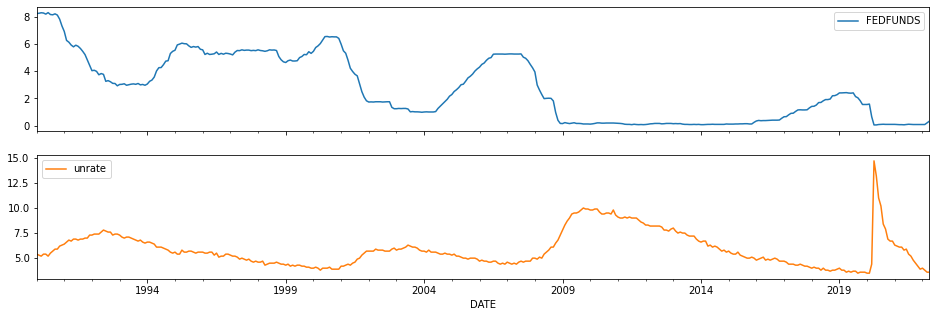

In [26]:
# Plot the datasets for visual inspection and understanding 
economic_df.plot(subplots=True)
plt.show()

In [28]:
# Check for stationarity. Stationarity is an important assumption in VAR

def check_stationarity(df):
    kps = kpss(df)
    adf = adfuller(df)
    kpss_pv, adf_pv = kps[1], adf[1]
    kpssh, adfh = 'Stationary', 'Non-stationary'
    if adf_pv < 0.05:
        # Reject ADF Null Hypothesis
        adfh = 'Stationary'
    if kpss_pv < 0.05:
        # Reject KPSS Null Hypothesis
        kpssh = 'Non-stationary'
    
    return (kpssh, adfh)


for i in economic_df:
    kps, adf = check_stationarity(economic_df[i])
    print(f'{i} adf: {adf}, kpss: {kps}')
    

FEDFUNDS adf: Stationary, kpss: Non-stationary
unrate adf: Stationary, kpss: Stationary


Granger causality tests are implemented in statsmodels with the grangercausalitytests function
which performs four tests across each past lag. We can control this using the maxlag parameter
Granger causality tests are used to determine if past values from one variable influence the other variable. In statsmodels, at each lag, it will show the tests that have been performed and their results: the test statistics score, the p_value, and the degrees of freedom. Let's focus on the p-value to decide if we should reject or accept the null hypothesis. 

The _null hypothesis_ in the Granger causality tests is that the second variable (or column) does not Granger cause the first variable (column). It assumes there is no statistical significance in terms of influence or effect. If we are trying to predict unreat and determine if FEDFUNDS influence unrate, we will need to switch the order of the columns, before applying the test. This is because _grangercausality_ examines the second column against the first column: 
  

In [29]:
granger = grangercausalitytests(economic_df[['unrate', 'FEDFUNDS']], maxlag=12)

# The test is set for a maximum of 12 lags (12 months). 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5415  , p=0.4623  , df_denom=384, df_num=1
ssr based chi2 test:   chi2=0.5457  , p=0.4601  , df=1
likelihood ratio test: chi2=0.5454  , p=0.4602  , df=1
parameter F test:         F=0.5415  , p=0.4623  , df_denom=384, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=21.6287 , p=0.0000  , df_denom=381, df_num=2
ssr based chi2 test:   chi2=43.8250 , p=0.0000  , df=2
likelihood ratio test: chi2=41.5108 , p=0.0000  , df=2
parameter F test:         F=21.6287 , p=0.0000  , df_denom=381, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=21.5527 , p=0.0000  , df_denom=378, df_num=3
ssr based chi2 test:   chi2=65.8554 , p=0.0000  , df=3
likelihood ratio test: chi2=60.7928 , p=0.0000  , df=3
parameter F test:         F=21.5527 , p=0.0000  , df_denom=378, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=16.1117 , p=0.0000  

Here, all the lags (except for lag 1) have a p-value less than 0.05, which indicates that we can reject the null hypothesis. This means that the effect of FEDFUNDS is statistically significant. We can say that FEDFUNDS does Granger cause unrate. 

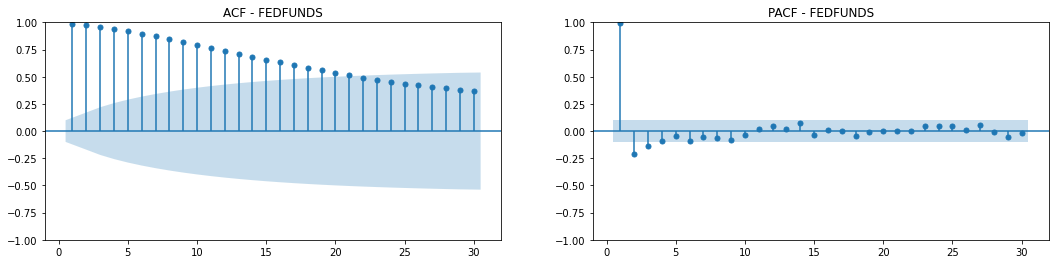

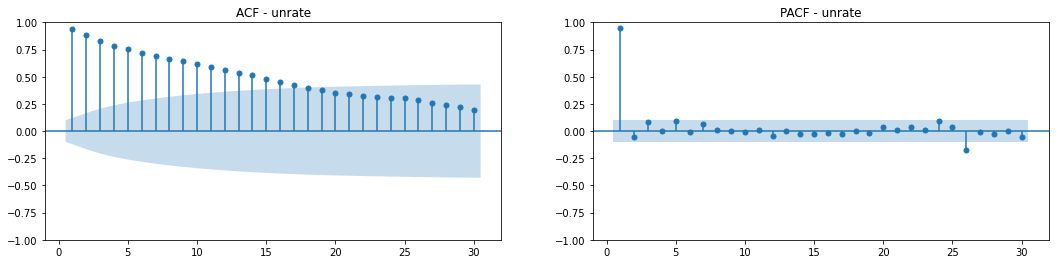

In [30]:
# Plot both ACF and PACF to gain an intuition over each variable and which process they belong to
# for example, an AR or MA process

for col in economic_df.columns:
    fig, ax = plt.subplots(1,2, figsize=(18,4))
    plot_acf(economic_df[col], zero=False, lags=30, ax=ax[0], title=f'ACF - {col}')
    plot_pacf(economic_df[col], zero=False, lags=30, ax=ax[1], title=f'PACF - {col}')

plt.show()

Notice that for FEDFUNDS and unrate, the plots indicate we are dealing with an autoregressive (AR) process. The ACF is gradually decaying, while both PACF plot show a sharp cutoff after lag 1. 

There is often a debate if the variables need to be scaled (standardized) or not when implementing VAR. Generally, when it comes to VAR, the algorithm does not require the variables to be scaled. Since we are working with multivariate time series (multiple variables) that may have different scales, it would be easier to interpret the residuals from each, if the data is scaled. Similarly, the coefficients will become easier to compare since the units will be in standard deviation. In this step, we will perform scaling as a best practice. We will use the StandardScaler class from Scikit-learn since it will provide us with the **inverse_transform** method so that we can return to the original scale. 

In [31]:
# Split the data into train and test sets 
train = economic_df.loc[:'2019']
test = economic_df.loc['2020':]

train.index 

DatetimeIndex(['1990-01-01', '1990-02-01', '1990-03-01', '1990-04-01',
               '1990-05-01', '1990-06-01', '1990-07-01', '1990-08-01',
               '1990-09-01', '1990-10-01',
               ...
               '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01',
               '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', name='DATE', length=360, freq='MS')

In [32]:
test.index 


DatetimeIndex(['2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
               '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01',
               '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01'],
              dtype='datetime64[ns]', name='DATE', freq='MS')

In [33]:
print(f'Train: {len(train)}, Test: {len(test)}')


Train: 360, Test: 28


In [34]:
from sklearn.preprocessing import StandardScaler 
scale = StandardScaler()
scale.fit(train)
train_sc = pd.DataFrame(scale.transform(train), 
                        index = train.index, 
                        columns=train.columns)
test_sc = pd.DataFrame(scale.transform(test), 
                       index=test.index, 
                       columns=test.columns)


In [35]:
test[0:5]

,FEDFUNDS,unrate
DATE,,
2020-01-01,1.55,3.5
2020-02-01,1.58,3.5
2020-03-01,0.65,4.4
2020-04-01,0.05,14.7
2020-05-01,0.05,13.2


In [36]:
scale.inverse_transform(test_sc)[0:5]

array([[ 1.55,  3.5 ],
       [ 1.58,  3.5 ],
       [ 0.65,  4.4 ],
       [ 0.05, 14.7 ],
       [ 0.05, 13.2 ]])

<AxesSubplot:xlabel='DATE'>

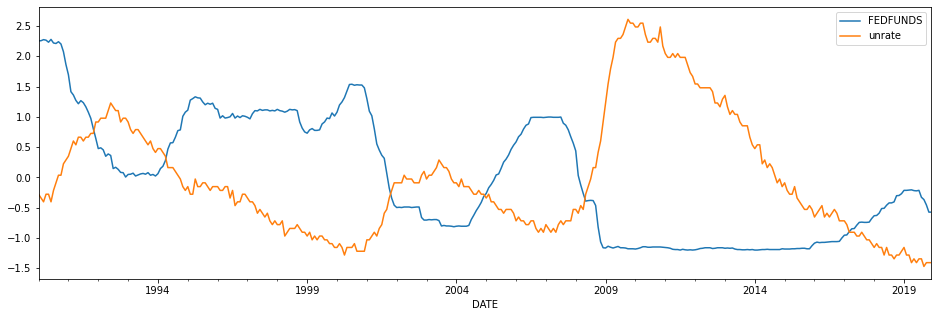

In [37]:
train_sc.plot()

In [38]:
train_sc.shape 

(360, 2)

In [39]:
test_sc.shape 

(28, 2)

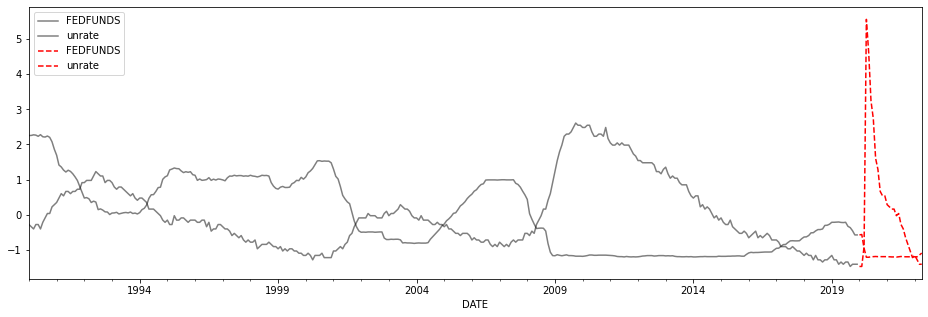

In [41]:
ax = train_sc.plot(style='k', alpha=0.5, label='train')
test_sc.plot(ax=ax, style='r--', label='test')
plt.legend()
plt.show()

How can we pick the VAR order p? The VAR implementation in statsmodels will pick the best VAR order. We only need to define the maximum number of lags. The model will determine the best p values that minimize each of the four information criteria scores. The _select_order_ method will compute the scores for each lag. The results will help when we train (fit) the model to specify which information criteria the algorithm should use:

In [42]:
model = VAR(endog=train_sc)
res = model.select_order(maxlags=10)
res.summary()

,AIC,BIC,FPE,HQIC
0,-0.3450,-0.3229,0.7083,-0.3362
1,-9.984,-9.918,4.611e-05,-9.958
2,-10.50,-10.39,2.746e-05,-10.46
3,-10.55,-10.40,2.613e-05,-10.49
4,-10.60,-10.40*,2.490e-05,-10.52*
5,-10.60,-10.35,2.500e-05,-10.50
6,-10.62,-10.33,2.447e-05,-10.50
7,-10.65*,-10.32,2.379e-05*,-10.51
8,-10.63,-10.25,2.421e-05,-10.48
9,-10.62,-10.20,2.447e-05,-10.45


In [43]:
res.selected_orders

{'aic': 7, 'bic': 4, 'hqic': 4, 'fpe': 7}

In [44]:
print(f'AIC: {res.aic}, BIC: {res.bic}, HQ: {res.hqic}, FPE: {res.fpe}')

AIC: 7, BIC: 4, HQ: 4, FPE: 7


In [45]:
results = model.fit(maxlags=7, ic='aic')

In [46]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 16, Apr, 2023
Time:                     00:48:41
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -10.3148
Nobs:                     353.000    HQIC:                  -10.5127
Log likelihood:           906.792    FPE:                2.38598e-05
AIC:                     -10.6434    Det(Omega_mle):     2.19544e-05
--------------------------------------------------------------------
Results for equation FEDFUNDS
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              -0.002763         0.002959           -0.934           0.350
L1.FEDFUNDS         1.438838         0.053660           26.814           0.000
L1.unrate          -0.070386         0.033673           -2.090   

In [47]:
type(results)

statsmodels.tsa.vector_ar.var_model.VARResultsWrapper

In [49]:
lag_order = results.k_ar
lag_order 

7

In [50]:
results.params 

,FEDFUNDS,unrate
const,-0.002763,-0.004557
L1.FEDFUNDS,1.438838,-0.224553
L1.unrate,-0.070386,0.929021
L2.FEDFUNDS,-0.314183,0.330518
L2.unrate,0.058783,0.143089
L3.FEDFUNDS,0.000892,-0.270533
L3.unrate,-0.029408,0.021951
L4.FEDFUNDS,-0.283291,0.219337
L4.unrate,0.048564,-0.032865
L5.FEDFUNDS,0.162109,-0.159646


In [51]:
train_sc[-lag_order:]

,FEDFUNDS,unrate
DATE,,
2019-06-01,-0.221874,-1.406816
2019-07-01,-0.213414,-1.344066
2019-08-01,-0.327635,-1.344066
2019-09-01,-0.365709,-1.469566
2019-10-01,-0.454548,-1.406816
2019-11-01,-0.573000,-1.406816
2019-12-01,-0.573000,-1.406816


<AxesSubplot:xlabel='DATE'>

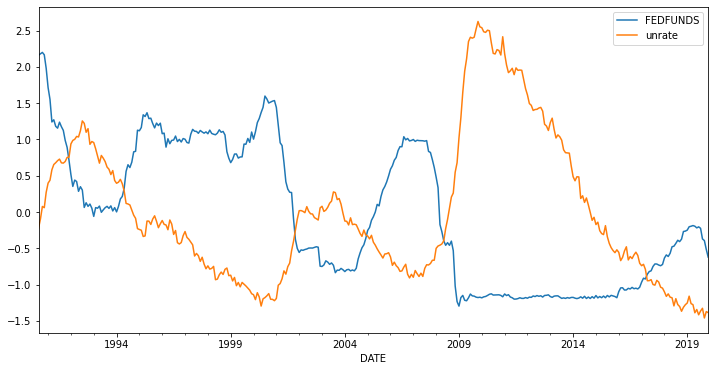

In [52]:
results.fittedvalues.plot(figsize=(12,6))

array([<AxesSubplot:xlabel='DATE'>, <AxesSubplot:xlabel='DATE'>],
      dtype=object)

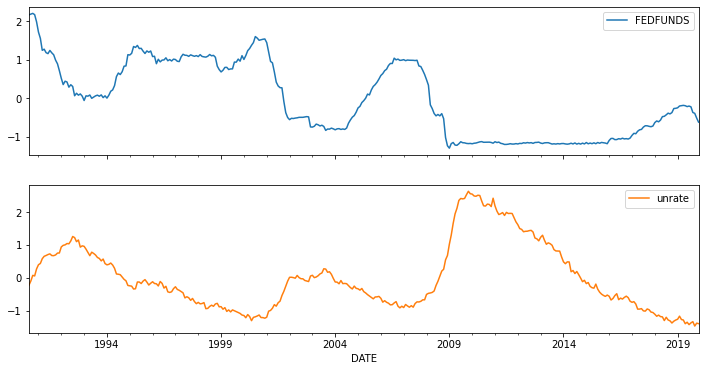

In [53]:
results.fittedvalues.plot(figsize=(12,6), subplots=True)

In [54]:
forecast[0:10]

1974-08-01    865.935050
1974-09-01    818.998134
1974-10-01    824.394440
1974-11-01    789.428776
1974-12-01    829.391865
1975-01-01    854.782508
1975-02-01    810.489877
1975-03-01    915.067271
1975-04-01    929.422664
1975-05-01    992.639754
Freq: MS, dtype: float64

Manually creating a similar plot 

In [55]:
past_y = train_sc[-lag_order:].values 
n = test_sc.shape[0]
forecast = results.forecast_interval(past_y, n)

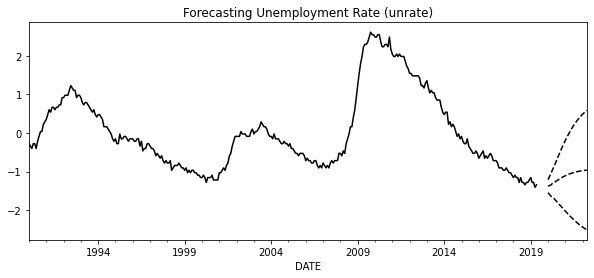

In [56]:
forecast, lower, upper = results.forecast_interval(past_y, steps=n)

idx = test.index 
style= 'k--'
ax = train_sc.iloc[:-lag_order, 1].plot(figsize=(10,4), style='k')
pred_forecat = pd.Series(forecast[:,1], index=idx).plot(ax=ax, style=style)
pred_lower = pd.Series(lower[:,1], index=idx).plot(ax=ax, style=style)
pred_upper = pd.Series(upper[:,1], index=idx).plot(ax=ax, style=style)
plt.title('Forecasting Unemployment Rate (unrate)')
plt.show()

Alternatively - using fill_between 

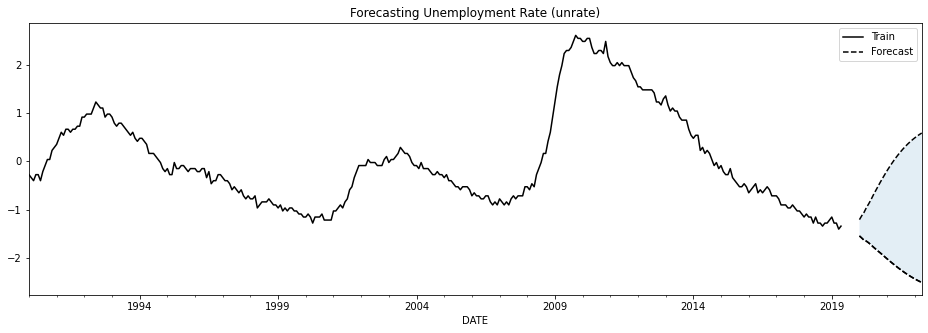

In [57]:
forecast, lower, upper = results.forecast_interval(past_y, steps=n)

idx = test.index
style='k--' 
ax = train_sc.iloc[:-lag_order, 1].plot(style='k')
pred_forecast = pd.Series(lower[:,1], index=idx).plot(ax=ax, style=style)
pred_lower = pd.Series(lower[:,1], index=idx).plot(ax=ax, style=style)
pred_upper = pd.Series(upper[:,1], index=idx).plot(ax=ax, style=style)
plt.fill_between(idx, lower[:,1], upper[:,1], alpha=0.12)
plt.title('Forecasting Unemployment Rate (unrate)')
plt.legend(['Train', 'Forecast'])
plt.show()

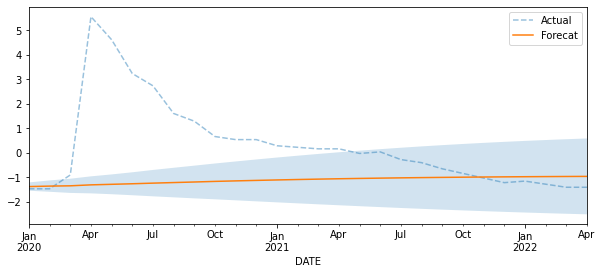

In [58]:
test_sc['unrate'].plot(style='--', alpha=0.45, figsize=(10, 4)).plot()
pd.Series(forecast[:,1], index=test_sc.index).plot()
plt.fill_between(idx, lower[:,1], upper[:,1], alpha=0.2)
plt.legend(['Actual', 'Forecat'])

* Comparing the results from VAR(7) with an AR(7)
* AR(7) is a univariate this way we are comparing using one variable (unrate) to see if using two variables are better or not
* Using ARIMA(7, 0, 0) indicates an AR(7)

In [59]:
from statsmodels.tsa.arima.model import ARIMA 


In [60]:
model = ARIMA(train_sc['unrate'], order=(lag_order, 0, 0)).fit()


In [61]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 unrate   No. Observations:                  360
Model:                 ARIMA(7, 0, 0)   Log Likelihood                 364.732
Date:                Sun, 16 Apr 2023   AIC                           -711.464
Time:                        01:14:24   BIC                           -676.489
Sample:                    01-01-1990   HQIC                          -697.557
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1032      0.448     -0.230      0.818      -0.982       0.776
ar.L1          0.9434      0.047     20.282      0.000       0.852       1.035
ar.L2          0.1797      0.068      2.634      0.008       0.046       0.313
ar.L3          0.0154      0.076      0.201      0.840      -0.134       0.165
ar.L4         -0.0311      0.075     -0.417      0.677      -0.178       0.115
ar.L5          0.0651      0.071      0.914      0.361      -0.074       0.205
ar.L6         -0.0159      0.075     -0.211      0.833      -0.164       0.132
ar.L7         -0.1677      0.052     -3.256      0.001      -0.269      -0.067
sigma2         0.0076      0.001     14.455      0.000       0.007       0.009
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 6.17
Prob(Q):                              0.87   Prob(JB):                         0.05
Heteroskedasticity (H):               1.15   Skew:                             0.19
Prob(H) (two-sided):                  0.45   Kurtosis:                         3.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

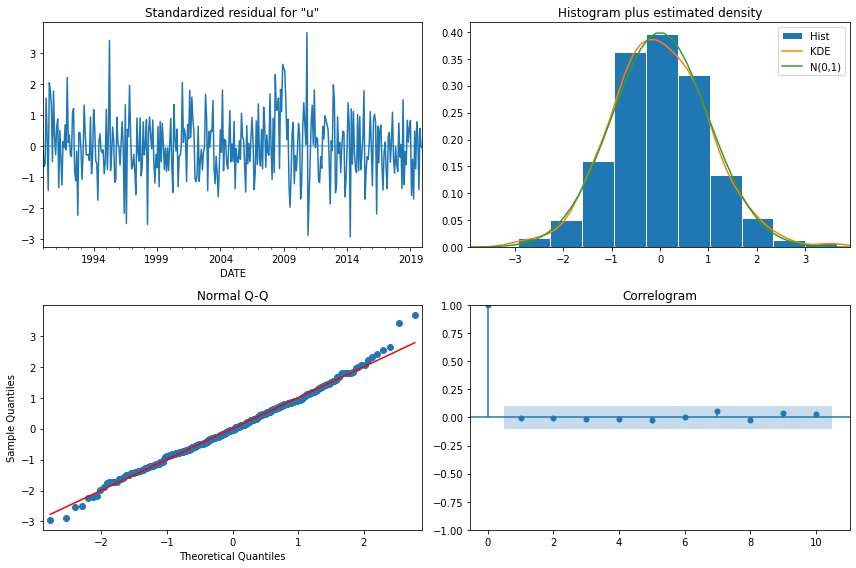

In [62]:
fig = model.plot_diagnostics(figsize=(12,8))
fig.tight_layout()
plt.show()

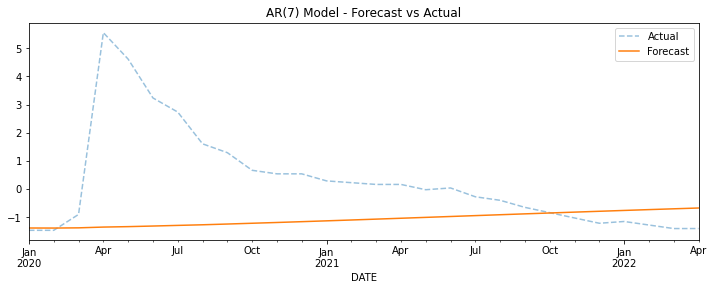

In [63]:
# Plotting the results from an AR(7)
plt.title('AR(7) Model - Forecast vs Actual')
test_sc['unrate'].plot(style='--', alpha=0.45, figsize=(12,4))
pd.Series(model.forecast(n), index=test_sc.index).plot()
plt.legend(['Actual', 'Forecast'])

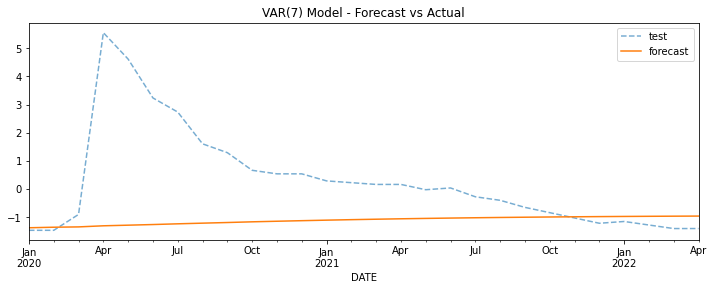

In [64]:
index = test_sc.index 
plt.title('VAR(7) Model - Forecast vs Actual')
ax = test_sc['unrate'].plot(style='--', alpha=0.6, figsize=(12,4))
pd.Series(forecast[:,1], index=index).plot(style='-', ax=ax)
plt.legend(['test', 'forecast'])
plt.show()

In [ ]:
from 